In [1]:
from ROOT import (TCanvas, TPad, TFile, TPaveLabel, 
                  TPaveText, gROOT, TH1F, TH1D, TLegend, 
                  gStyle, TH2F, TChain, TGraphErrors, TText, gPad, gROOT, TTree)
from array import array
import datetime
import numpy as np

np.random.seed(42)
        
from keras.models import Sequential, Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from keras.optimizers import Adagrad, SGD, RMSprop, Adam

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, LSTM, Conv1D, SimpleRNN, Concatenate
from keras import optimizers
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import keras.backend as K
import pickle
#import seaborn as sns

TODAY = datetime.datetime.now().strftime('%Y-%m-%d')

def init_dirs():
    import datetime, os
    for _dir in ["plots", "models"]:
        today_dir = os.path.join(_dir, TODAY)
        if not os.path.isdir(today_dir):
            os.makedirs(today_dir)
            
#init_dirs()
from sklearn import preprocessing
from keras import regularizers
import tensorflow as tf

Welcome to JupyROOT 6.22/08


In [ ]:
# all methods here
MASS_FEATURE_INDEX = 0

# Takes as dataframe xbtrain and xstrain
def prep_mass(xbtrain, xstrain, norm=None):
    np.random.seed(42)
    new  = xbtrain.copy()
    sump = sum(xstrain[:,-1])
    for d in new:
        mass = np.random.choice(xstrain[:,MASS_FEATURE_INDEX], p=1/sump*xstrain[:,-1])
        if norm:
            mass = mass / norm
        d[MASS_FEATURE_INDEX] = mass
    return new

def unison_shuffled_copies(*arr):
    assert all(len(a) for a in arr)
    p = np.random.permutation(len(arr[0]))
    return (a[p] for a in arr)

In [2]:
import pandas as pd

In [87]:
mstop_175   = pd.read_pickle('DNN_ips/SUSY_Mstop_175_mchi_7_5.pkl')
mstop_182_5 = pd.read_pickle('DNN_ips/SUSY_Mstop_182_5_mchi_7_5.pkl')
mstop_190   = pd.read_pickle('DNN_ips/SUSY_Mstop_190_mchi_7_5.pkl')

mstop_227_5 = pd.read_pickle('DNN_ips/SUSY_Mstop_227_5_mchi_60.pkl')
mstop_235   = pd.read_pickle('DNN_ips/SUSY_Mstop_235_mchi_60.pkl')
mstop_242_5 = pd.read_pickle('DNN_ips/SUSY_Mstop_242_5_mchi_60.pkl')

tt_df     = pd.read_pickle('DNN_ips/ttbar.pkl')
st_df     = pd.read_pickle('DNN_ips/Single_top.pkl')
vv_df     = pd.read_pickle('DNN_ips/VV.pkl')

In [88]:
mstop_175['mass']   = 175   * np.ones(len(mstop_175))
mstop_182_5['mass'] = 182.5 * np.ones(len(mstop_182_5))
mstop_190['mass']   = 190   * np.ones(len(mstop_190))

In [89]:
mstop_227_5['mass'] = 227.5 * np.ones(len(mstop_227_5))
mstop_235['mass']   = 235   * np.ones(len(mstop_235))
mstop_242_5['mass'] = 242.5 * np.ones(len(mstop_242_5))

In [98]:
len(mstop_242_5)/len(sig_df)

0.06543546828372078

In [100]:
def add_mass(df) :
    mass_array = [175, 182.5, 190, 227.5, 235, 242.5]
    df['mass'] = np.random.choice(mass_array, len(df), [0.26, 0.28, 0.23, 0.08, 0.08, 0.07])
    return df

In [101]:
add_mass(tt_df)
add_mass(st_df)
add_mass(vv_df)

,lepton_pt,lepton_eta,lepton_phi,sublepton_pt,sublepton_eta,sublepton_phi,ljet_pt,ljet_eta,ljet_phi,sljet_pt,sljet_eta,sljet_phi,llbar_dphi,llbar_deta,bbbar_dphi,bbbar_deta,MET,HT,ST,mass
0,33.049122,0.337251,-0.707851,20.364117,0.234310,-1.825370,59.519379,-1.494468,-1.809095,37.361656,-0.825658,1.201528,1.117519,0.102941,3.010623,0.668810,53.335976,185.653427,245.690353,242.5
1,131.584351,-1.082311,-1.488291,27.348965,-0.353577,1.174748,197.210983,-1.607147,2.587804,53.675026,-1.190631,-0.999964,2.663038,0.728735,2.695418,0.416516,131.167969,436.514771,609.678528,242.5
2,179.116760,0.631746,0.806323,34.501385,0.602261,-2.888527,181.742630,1.678373,-1.450026,70.926750,0.605042,-0.961532,2.588336,0.029485,0.488495,1.073331,150.282364,489.410339,710.519897,227.5
3,103.549088,-1.385566,-1.807048,79.499565,-0.231480,-0.007435,436.097137,1.459959,2.989566,89.968910,-1.707300,-2.672297,1.799613,1.154085,0.621323,3.167259,419.472290,915.183472,1127.293213,190.0
4,49.766468,1.114702,1.446416,47.694019,1.326512,1.954132,247.103897,-1.437426,-1.021577,32.812466,-2.059705,-1.096815,0.507716,0.211810,0.075238,0.622279,271.417267,442.043518,546.532959,190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19164,162.643326,-0.824146,0.933549,41.495518,0.517160,2.765465,71.897385,-2.004466,-2.124933,37.614384,-0.365030,1.034045,1.831916,1.341306,3.124208,1.639435,81.155060,374.993866,583.946350,182.5
19165,87.763779,-0.618857,-2.305605,38.950542,1.669836,2.139218,161.004440,1.069902,-0.812879,43.238068,0.184528,1.257501,1.838362,2.288693,2.070380,0.885374,132.962646,367.684570,504.127563,175.0
19166,72.913467,0.755574,-0.271469,62.879185,2.265260,-2.749144,82.524139,-1.577390,1.296614,58.682117,0.443310,2.328966,2.477675,1.509686,1.032352,2.020700,90.588600,356.668549,499.814850,227.5
19167,186.793900,0.468060,2.511513,20.719324,-0.040583,2.252061,99.387131,-0.330927,-0.917914,93.833412,-0.083395,-0.409145,0.259452,0.508643,0.508769,0.247533,77.907112,546.412659,759.563354,242.5


In [90]:
sig_list = [mstop_175, mstop_182_5, mstop_190, mstop_227_5, mstop_235, mstop_242_5]
sig_df   = pd.concat(sig_list)

In [91]:
sig_df   = sig_df.sample(frac=1)

In [99]:
sig_df

,lepton_pt,lepton_eta,lepton_phi,sublepton_pt,sublepton_eta,sublepton_phi,ljet_pt,ljet_eta,ljet_phi,sljet_pt,sljet_eta,sljet_phi,llbar_dphi,llbar_deta,bbbar_dphi,bbbar_deta,MET,HT,ST,mass
22432,43.106159,0.549739,3.086731,39.481808,-1.358600,0.137142,55.183983,-1.277269,-0.260083,40.558800,0.994124,0.481001,2.949589,1.908339,0.741084,2.271393,48.864693,254.031342,347.823761,175.0
129868,45.051491,-0.948394,1.598568,24.017239,-0.061329,0.735389,118.252930,0.215724,2.514487,82.710052,-1.800771,-0.933622,0.863179,0.887066,2.835077,2.016495,61.824657,394.195374,483.112518,182.5
5632,48.628716,-1.637328,-1.054992,44.682827,-1.482058,-1.679641,130.323669,-0.871994,1.460108,57.132717,-0.894634,-0.561603,0.624649,0.155270,2.021711,0.022640,75.153839,382.360382,600.245605,175.0
30182,55.160995,-1.791398,1.255452,52.507133,-1.328997,-0.054862,152.889648,-0.539348,-1.728274,56.601898,-0.054165,-2.217833,1.310313,0.462401,0.489559,0.485183,87.376968,471.881165,596.981201,175.0
90153,81.220024,-1.576282,-0.203475,24.491945,-1.865013,1.244024,223.407990,0.162308,-1.727503,161.055878,0.162146,2.619174,1.447499,0.288731,1.936509,0.000162,70.613174,582.770386,753.102234,182.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89310,72.942917,-0.313908,-0.964318,28.946402,0.430394,2.385913,67.550049,-2.374164,0.253792,55.976913,-0.535645,-2.429983,2.932955,0.744302,2.683776,1.838519,47.942253,268.550903,374.380768,175.0
50895,156.262314,0.193874,-2.312100,44.415504,1.010242,-0.984498,429.242432,1.672948,0.825939,161.455963,0.911738,-2.781756,1.327602,0.816368,2.675491,0.761210,68.617767,880.238953,1088.809448,182.5
18176,45.728035,-0.508294,-2.264784,21.624714,-0.051167,1.878418,87.197510,-1.173718,1.652256,48.722759,-0.955569,-2.310387,2.139983,0.457128,2.320543,0.218148,87.026543,203.273010,300.299194,175.0
74307,44.450062,0.765803,2.523708,43.782413,-0.592102,-2.593304,112.270798,-1.277091,-1.562969,76.969078,1.709650,-0.190578,1.166173,1.357905,1.372391,2.986741,86.289818,527.093872,640.209351,182.5


In [102]:
sig_df_train = sig_df[1:200000]
tt_df_train  = tt_df[1:200000]
st_df_train  = st_df[1:60000]
vv_df_train  = vv_df[1:10000]

In [103]:
# Standardize
sig_mean = sig_df_train.mean()
sig_std  = sig_df_train.std()

tt_mean = tt_df_train.mean()
tt_std  = tt_df_train.std()

st_mean = st_df_train.mean()
st_std  = st_df_train.std()

vv_mean = vv_df_train.mean()
vv_std  = vv_df_train.std()

sig_df_train = (sig_df_train - sig_mean)/ sig_std
tt_df_train  = (tt_df_train  - tt_mean)/ tt_std
st_df_train  = (st_df_train  - st_mean)/ st_std
vv_df_train  = (vv_df_train  - vv_mean)/ vv_std

In [104]:
sig_df_test = sig_df[200000:]
tt_df_test  = tt_df[200000:]
st_df_test  = st_df[60000:]
vv_df_test  = vv_df[10000:]

In [105]:
# Standardize
sig_mean = sig_df_test.mean()
sig_std  = sig_df_test.std()

tt_mean = tt_df_test.mean()
tt_std  = tt_df_test.std()

st_mean = st_df_test.mean()
st_std  = st_df_test.std()

vv_mean = vv_df_test.mean()
vv_std  = vv_df_test.std()

sig_df_test = (sig_df_test - sig_mean)/ sig_std
tt_df_test  = (tt_df_test  - tt_mean)/ tt_std
st_df_test  = (st_df_test  - st_mean)/ st_std
vv_df_test  = (vv_df_test  - vv_mean)/ vv_std

In [106]:
bkgList = [tt_df_train, st_df_train, vv_df_train]  # List of your dataframes

bkg_df_train = pd.concat(bkgList)

signal    = sig_df_train.values
bkg       = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))

In [107]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(data, label)
skf.split(data, label)

<generator object _BaseKFold.split at 0x7f5d13337c10>

In [108]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    #x_train_wt, x_test_wt = sample_wts[train_index], sample_wts[test_index]

TRAIN: [     0      6      7 ... 469991 469994 469995] TEST: [     1      2      3 ... 469987 469992 469993]
TRAIN: [     1      2      3 ... 469987 469992 469993] TEST: [     0      6      7 ... 469991 469994 469995]


In [109]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout , BatchNormalization
from skopt        import gp_minimize

model = Sequential()
model.add(Dense(150, input_dim = 20 ,activation='relu'))
model.add(Dropout(0.4))
#model.add(BatchNormalization())
model.add(Dense(150, input_dim = 150 ,activation='relu'))
model.add(Dropout(0.4))
#model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 150)               3150      
_________________________________________________________________
dropout_6 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 151       
Total params: 25,951
Trainable params: 25,951
Non-trainable params: 0
_________________________________________________________________


In [71]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [110]:
hist = model.fit(x_train, y_train, batch_size=100, epochs=20,verbose=1, shuffle=True, validation_split=0.20,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model.h5', verbose=0)])

Epoch 1/20
1880/1880 [==============================] - 3s 2ms/step - loss: 0.6196 - accuracy: 0.6097 - val_loss: 0.2498 - val_accuracy: 0.8434
Epoch 2/20
1880/1880 [==============================] - 3s 2ms/step - loss: 0.2400 - accuracy: 0.8754 - val_loss: 0.1960 - val_accuracy: 0.8409
Epoch 3/20
1880/1880 [==============================] - 3s 2ms/step - loss: 0.1720 - accuracy: 0.9137 - val_loss: 0.0319 - val_accuracy: 0.9986
Epoch 4/20
1880/1880 [==============================] - 3s 2ms/step - loss: 0.0496 - accuracy: 0.9879 - val_loss: 0.0058 - val_accuracy: 0.9994
Epoch 5/20
1880/1880 [==============================] - 3s 2ms/step - loss: 0.0216 - accuracy: 0.9945 - val_loss: 0.0140 - val_accuracy: 0.9970
Epoch 6/20
1880/1880 [==============================] - 3s 2ms/step - loss: 0.0183 - accuracy: 0.9950 - val_loss: 0.0062 - val_accuracy: 0.9985
Epoch 7/20
1880/1880 [==============================] - 3s 2ms/step - loss: 0.0157 - accuracy: 0.9956 - val_loss: 0.0018 - val_accuracy:

In [79]:
import matplotlib.pyplot as plt
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Loss' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Loss by Epoch', fontsize=17)
    color='C0'
    do_acc=False
    for label,loss in histories:
        #color = tuple(np.random.random(3))
        #colors.append(color)
        l = 'Training set loss'
        vl= 'Validation set loss'
        if 'accuracy' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['accuracy'][-1])
            do_acc = True
        if 'val_accuracy' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_accuracy'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color='C0')
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color='C0')

    plt.legend(fontsize=17)
    #plt.yscale('log')
    plt.show()
    
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Accuracy' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    for i,(label,loss) in enumerate(histories):
        #color = colors[i]
        if 'accuracy' in loss.history:
            plt.plot(loss.history['accuracy'], lw=2, label=label+" accuracy", color=color)
        if 'val_accuracy' in loss.history:
            plt.plot(loss.history['val_accuracy'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(fontsize=17)
    plt.show()

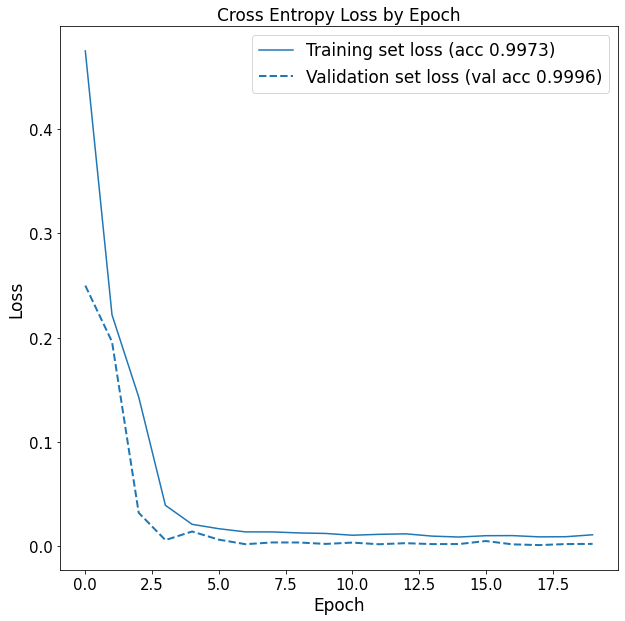

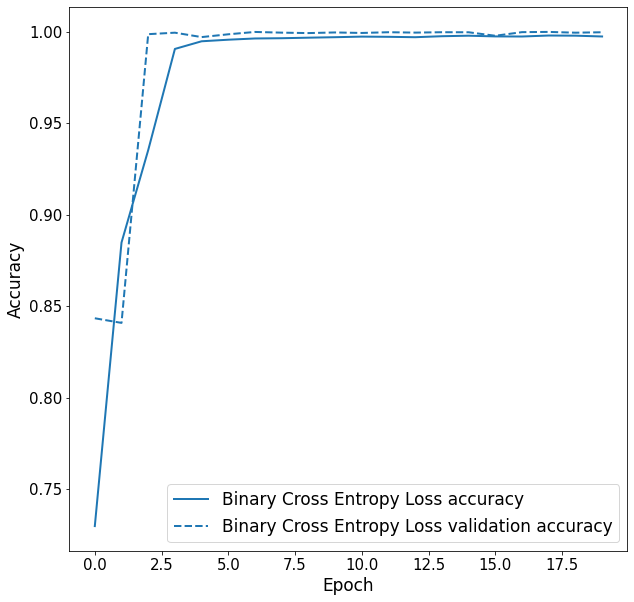

In [111]:
show_losses( [("Binary Cross Entropy Loss", hist)])

In [115]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(x_train).ravel()
y_pred_test  = model.predict(x_test).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(y_train, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(y_test , y_pred_test)

In [116]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

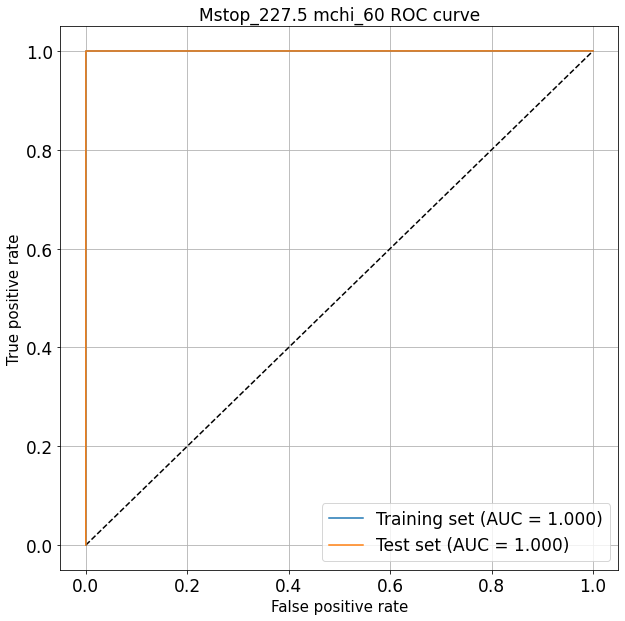

In [117]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.tick_params(axis="y", labelsize=17)
plt.tick_params(axis="x", labelsize=17)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_227.5 mchi_60 ROC curve', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
#plt.savefig('ROC Mstop 227.5 Mchi 60.jpg')
plt.show()

In [112]:
tt_pred  = model.predict(tt_df_test) 
st_pred  = model.predict(st_df_test)
vv_pred  = model.predict(vv_df_test) 
si_pred  = model.predict(sig_df_test)

2021-08-17 00:57:43.277924: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209260320 exceeds 10% of free system memory.


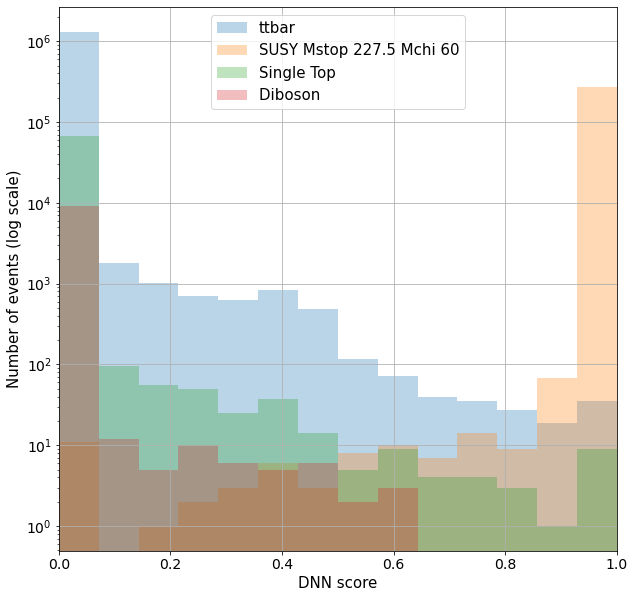

In [114]:
binning = np.linspace(0,1,15)
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(tt_pred, bins=binning, alpha=0.3, label='ttbar')
plt.hist(si_pred, bins=binning, alpha=0.3, label='SUSY Mstop 227.5 Mchi 60')
plt.hist(st_pred, bins=binning, alpha=0.3, label='Single Top')
plt.hist(vv_pred, bins=binning, alpha=0.3, label='Diboson ')
#plt.hist(sat_pred, bins=binning, alpha=0.3, label='Single Antitop')
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
#plt.savefig('DNN_score_Mstop_227_5_Mchi_60.jpg')

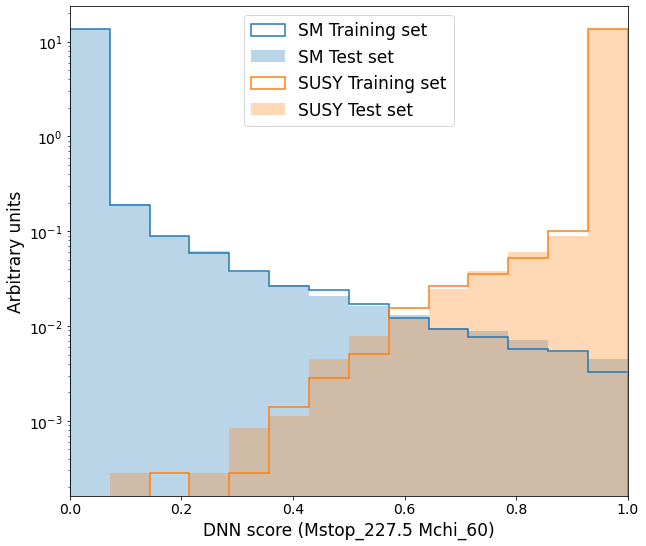

In [86]:
c0 = 'C0'
c1 = 'C1'
binning = np.linspace(0,1,15)
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=binning, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
plt.hist(y_pred_test[y_test == 0]  , bins=binning, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
plt.hist(y_pred_train[y_train == 1], bins=binning, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
plt.hist(y_pred_test[y_test == 1]  , bins=binning, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

plt.yscale('log')
#plt.ylim(0.01, 20)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_227.5 Mchi_60)', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)
#plt.savefig('Train vs test Mstop_227.5 Mchi_60.jpg')

<ipython-input-118-c75dc0f6f979>:21: RuntimeWarning: divide by zero encountered in true_divide
  ns1 / ns2,  # maybe check for div-by-zero!
<ipython-input-118-c75dc0f6f979>:31: RuntimeWarning: divide by zero encountered in true_divide
  ns3 / ns4,  # maybe check for div-by-zero!
<ipython-input-118-c75dc0f6f979>:31: RuntimeWarning: invalid value encountered in true_divide
  ns3 / ns4,  # maybe check for div-by-zero!


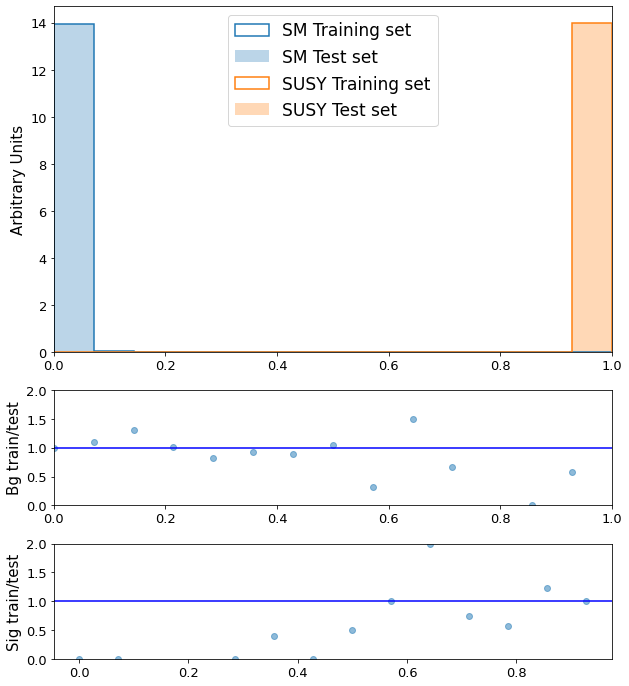

In [118]:
x_low    =  0
x_high   =  1

binning = np.linspace(x_low,x_high, 15)

ratio_fig_style = {
    'figsize': (10, 12),
    'gridspec_kw': {'height_ratios': (3, 1, 1)},
}

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, **ratio_fig_style)

ns1, bins1, patches  = ax1.hist(y_pred_train[y_train == 0], bins=binning, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
ns2, bins2, patches  = ax1.hist(y_pred_test[y_test == 0]  , bins=binning, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
ns3, bins3, patches  = ax1.hist(y_pred_train[y_train == 1], bins=binning, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
ns4, bins4, patches  = ax1.hist(y_pred_test[y_test == 1]  , bins=binning, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

ax1.legend(prop={'size': 17}, loc='upper center')
ax1.set_xlim(x_low,x_high)
ax2.scatter(binning[:-1],  # this is what makes it comparable
               ns1 / ns2,  # maybe check for div-by-zero!
                alpha=0.5)

ax1.set_ylabel('Arbitrary Units', fontsize=15)
ax2.set_ylabel('Bg train/test' , fontsize=15)
#ax2.set_xlabel('ttbar mass (GeV)', fontsize=15)
ax2.set_ylim(0, 2)
ax2.set_xlim(x_low,x_high)

ax3.scatter(binning[:-1],  # this is what makes it comparable
               ns3 / ns4,  # maybe check for div-by-zero!
                alpha=0.5)

ax3.set_ylabel('Sig train/test', fontsize=15)
ax3.set_ylim(0, 2)

ax1.tick_params(axis="x", labelsize=13)
ax2.tick_params(axis="x", labelsize=13)
ax3.tick_params(axis="x", labelsize=13)

ax1.tick_params(axis="y", labelsize=13)
ax2.tick_params(axis="y", labelsize=13)
ax3.tick_params(axis="y", labelsize=13)

ax2.axhline(y=1, color='b', linestyle='-')
ax3.axhline(y=1, color='b', linestyle='-')
plt.show()